In [61]:
import pandas as pd
import data_collection as dc
import prediction_model as pm
import sklearn.metrics as metrics
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import datetime
import talos
import math
import numpy as np

In [10]:
def add_lag_diff(df, begin, end, interval, dropna=True):
    df_lag = df.copy()
    columns = df.columns
    for column in columns:
        if column.lower() == 'date':
            continue
        for i in range(begin, end, interval):
            df_lag[f'{column}_{i}_lag'] = df_lag[column].shift(i)  # lags in days
            df_lag[f'{column}_{i}_diff'] = df_lag[f'{column}_{i}_lag'].diff()  # difference
    return df_lag.dropna() if dropna else df_lag

In [11]:
geo = "BE"
url_trends = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/trends/model/"
url_hospi = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/hospi/be-covid-hospi.csv"
full_df = pm.create_df_trends_url(url_hospi, geo)
full_data, full_data_no_rolling = pm.google_trends_process(full_df, pm.list_topics, start_year=2020, start_mon=2,
                                                           stop_year=2020,
                                                          stop_mon=9, step=1, data_collection=False)
shifted_df = add_lag_diff(full_data, 7, 14, 1)
shifted_df = shifted_df.reset_index().set_index('DATE')
shifted_df = shifted_df.drop(columns=['LOC'])
shifted_df

DL BE Fièvre
DL BE Mal de gorge
DL BE Dyspnée
DL BE Agueusie
DL BE Anosmie
DL BE Coronavirus
DL BE Virus
DL BE Température corporelle humaine
DL BE Épidémie
DL BE Symptôme
DL BE Thermomètre
DL BE Grippe espagnole
DL BE Paracétamol
DL BE Respiration
DL BE Toux


,Fièvre,Mal de gorge,Dyspnée,Agueusie,Anosmie,Coronavirus,Virus,Température corporelle humaine,Épidémie,Symptôme,...,HOSP_CORR_9_lag,HOSP_CORR_9_diff,HOSP_CORR_10_lag,HOSP_CORR_10_diff,HOSP_CORR_11_lag,HOSP_CORR_11_diff,HOSP_CORR_12_lag,HOSP_CORR_12_diff,HOSP_CORR_13_lag,HOSP_CORR_13_diff
DATE,,,,,,,,,,,,,,,,,,,,,
2020-03-18,0.875211,0.666075,1.000000,-0.054230,-0.030120,0.709091,0.609756,0.513514,0.596522,0.615764,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-19,0.726813,0.531083,0.712984,0.162690,0.337349,0.619835,0.480836,0.243243,0.506087,0.467980,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-20,0.591906,0.460036,0.485194,0.158351,0.638554,0.533884,0.393728,0.360360,0.426087,0.313629,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-21,0.433390,0.349911,0.271071,0.353579,0.795181,0.441322,0.306620,0.346847,0.370435,0.218391,...,0.018057,0.018057,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-22,0.328836,0.275311,0.271071,0.644252,0.921687,0.368595,0.236934,0.247748,0.325217,0.175698,...,0.040946,0.022889,0.018057,0.018057,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-11,-0.430017,-0.207815,-0.189066,0.388286,-0.331325,-0.666116,-0.874564,-0.495495,-0.878261,-0.264368,...,0.144201,0.006612,0.137589,0.010173,0.127416,0.005595,0.121821,-0.001526,0.123347,0.001017
2020-10-12,-0.463744,-0.253996,-0.184510,0.453362,-0.433735,-0.656198,-0.871080,-0.486486,-0.850435,-0.218391,...,0.149288,0.005086,0.144201,0.006612,0.137589,0.010173,0.127416,0.005595,0.121821,-0.001526
2020-10-13,-0.446880,-0.229130,-0.125285,0.505423,-0.433735,-0.609917,-0.871080,-0.445946,-0.808696,-0.208539,...,0.161495,0.012208,0.149288,0.005086,0.144201,0.006612,0.137589,0.010173,0.127416,0.005595


In [12]:
X_train = shifted_df[:'2020-09-15'].drop(['HOSP_CORR'], axis = 1)
y_train = shifted_df.loc[:'2020-09-15', 'HOSP_CORR']
X_test = shifted_df['2020-09-16':].drop(['HOSP_CORR'], axis = 1)
y_test = shifted_df.loc['2020-09-16':, 'HOSP_CORR']

In [13]:
models = []
models.append(('LR', LinearRegression()))
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))


LR: -0.048522 (0.038624)


(196.0, 211.0)

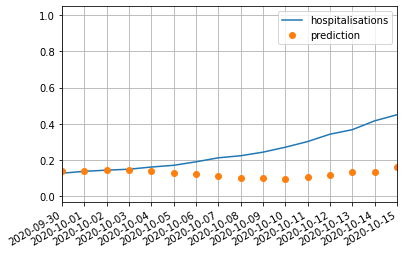

In [14]:
pred = models[0][1].fit(X_train, y_train)
x = pd.concat([X_train, X_test], axis=1).index
y = pd.concat([y_train, y_test], axis=0)
x_pred = X_test.index
y_pred = pred.predict(X_test)
# plot the actual hospitalisations and predictions
fig = plt.figure()
plt.plot(x, y, label='true hospitalisations')
plt.plot(x_pred, y_pred, 'o', label='prediction')
plt.grid()
plt.legend()
x_max = str(datetime.datetime.strptime(x_pred.max(), '%Y-%m-%d').date())
delay = datetime.timedelta(days = 15)
x_min = str((datetime.datetime.strptime(x.max(), '%Y-%m-%d') - delay).date())
fig.autofmt_xdate()
plt.xlim([x_min, x_max])

In [65]:
# split into train and test sets
train_size = int(len(full_data.values) * 0.8)
test_size = len(full_data.values) - train_size
train, test = full_data.values[0:train_size,:], full_data.values[train_size:len(full_data.values),:]
train

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = pm.create_dataset(train)
testX, testY = pm.create_dataset(test)

# reshape input to be [samples, time steps, features]
trainX = trainX.reshape((trainX.shape[0], trainX.shape[2], 1))
testX = testX.reshape((testX.shape[0], testX.shape[2], 1))

# create and fit the LSTM network
model = pm.Sequential()
model.add(pm.LSTM(4, input_shape=(1, pm.look_back)))
model.add(pm.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
#trainPredict = scaler.inverse_transform(trainPredict)
#trainY = scaler.inverse_transform([trainY])
#testPredict = scaler.inverse_transform(testPredict)
#testY = scaler.inverse_transform([testY])

# calculate root mean squared error
print('True value of y : ', testY[0])
print('Prediction of y : ', trainPredict[:,0])
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(full_data.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[pm.look_back:len(trainPredict)+pm.look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(full_data.values)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(pm.look_back*2)+1:len(full_data.values)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(full_data.values))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Epoch 1/100
161/161 - 5s - loss: 0.0012
Epoch 2/100
161/161 - 5s - loss: 8.1858e-04
Epoch 3/100
161/161 - 4s - loss: 6.5831e-04
Epoch 4/100
161/161 - 4s - loss: 5.8219e-04
Epoch 5/100
161/161 - 5s - loss: 4.7895e-04
Epoch 6/100
161/161 - 4s - loss: 4.4592e-04
Epoch 7/100
161/161 - 4s - loss: 3.3859e-04
Epoch 8/100
161/161 - 5s - loss: 2.5442e-04
Epoch 9/100
161/161 - 5s - loss: 1.5174e-04
Epoch 10/100
161/161 - 5s - loss: 1.2147e-04
Epoch 11/100
161/161 - 4s - loss: 1.2302e-04
Epoch 12/100
161/161 - 4s - loss: 9.0494e-05
Epoch 13/100
161/161 - 4s - loss: 1.2319e-04
Epoch 14/100
161/161 - 4s - loss: 1.0442e-04
Epoch 15/100
161/161 - 5s - loss: 1.3036e-04
Epoch 16/100
161/161 - 5s - loss: 1.1060e-04
Epoch 17/100
161/161 - 5s - loss: 1.4297e-04
Epoch 18/100
161/161 - 5s - loss: 1.2375e-04
Epoch 19/100
161/161 - 5s - loss: 1.0833e-04
Epoch 20/100
161/161 - 5s - loss: 9.0387e-05
Epoch 21/100
161/161 - 4s - loss: 1.0697e-04
Epoch 22/100
161/161 - 5s - loss: 1.0143e-04
Epoch 23/100
161/161 - 

TypeError: Singleton array 0.018056968463886065 cannot be considered a valid collection.

In [ ]:
train_data = {}
valid_data = {}
test_data = {}
full_datapoints = {}
full_data = shifted_df 

x, y = pm.create_dataset(full_data.values)
full_datapoints = (x, y)
assert pm.n_features == -1 or pm.n_features == x.shape[-1]
pm.n_features = x.shape[-1]

x, y = full_datapoints
length = x.shape[0]
train_len = int(length * pm.train_ratio)
valid_len = int(length * pm.valid_ratio)

train_data = (x[0:train_len], y[0:train_len])
valid_data = (x[train_len:train_len + valid_len], y[train_len:train_len + valid_len])
test_data = (x[train_len + valid_len:], y[train_len + valid_len:])

p = pm.define_parameters()

scan_object = talos.Scan(
            x=[],
            y=[],
            x_val=[],
            y_val=[],
            params=p,
            model=pm.create_model,
            experiment_name='trends1',
            fraction_limit=0.01
        )

analyze_object = talos.Analyze(scan_object)
print("MAE", analyze_object.low('mae'))
print("MSE", analyze_object.low('mse'))
print("VAL MAE", analyze_object.low('val_mae'))
print("VAL MSE", analyze_object.low('val_mse'))
analyze_object.table('val_mse', exclude=[], ascending=True)

# Finding the model that minimises the value of the MSE
best_model = scan_object.best_model('val_mse', asc=True)